In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
light_blue = np.array([75, 172, 123])
dark_blue = np.array([179, 255, 255])

light_pink = np.array([128,38,56])
dark_pink = np.array([164,255,255])

light_green = np.array([38,23,45])
dark_green = np.array([52,255,255])

light_yellow = np.array([94,135,90])
dark_yellow = np.array([130,255,255])

In [4]:
hsv_frame = cv2.imread('PINK&YELLOW.jpg', -1)
hsv_frame = cv2.cvtColor(hsv_frame, cv2.COLOR_BGR2HSV)

In [5]:
blue_mask = cv2.inRange(hsv_frame, light_blue, dark_blue)
pink_mask = cv2.inRange(hsv_frame, light_pink, dark_pink)
green_mask = cv2.inRange(hsv_frame, light_green, dark_green)
yellow_mask = cv2.inRange(hsv_frame, light_yellow, dark_yellow)

In [6]:
# image_result = cv2.bitwise_or(blue_mask, pink_mask)
# image_result = cv2.bitwise_or(image_result, green_mask)
# image_result = cv2.bitwise_or(green_mask, yellow_mask)
image_result = cv2.bitwise_or(pink_mask, yellow_mask)
kernel = np.ones((3, 3), np.uint8)
image_result = cv2.dilate(image_result, kernel, iterations=1)

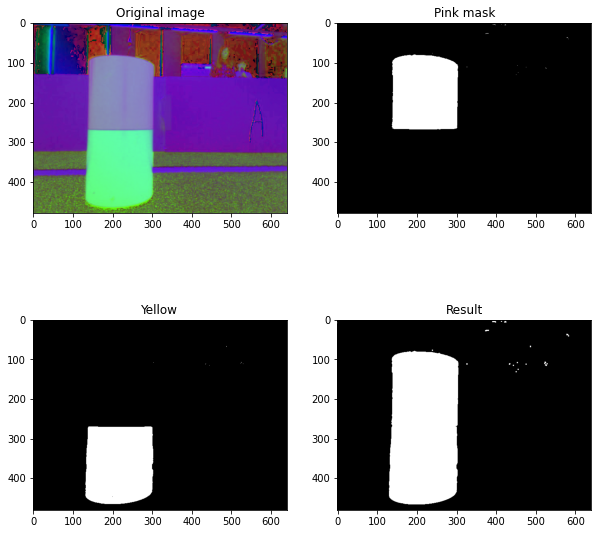

In [7]:
plt.figure(figsize=(10,10))
# Original image
plt.subplot(2,2,1)
plt.title("Original image")
plt.imshow(hsv_frame)

plt.subplot(2,2,2)
plt.title("Pink mask")
plt.imshow(pink_mask,cmap='gray',vmin=0,vmax=255)

plt.subplot(2,2,3)
plt.title("Yellow")
plt.imshow(yellow_mask,cmap='gray',vmin=0,vmax=255)

plt.subplot(2,2,4)
plt.title("Result")
plt.imshow(image_result,cmap='gray',vmin=0,vmax=255)

In [8]:
output = cv2.connectedComponentsWithStats(image_result, 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
cens = []
objects = []
for i in range(0, numLabels):
    if i != 0 and stats[i][4] > 150:
        cens.append(centroids[i])
        objects.append({"x": stats[i][0], "y": stats[i][1], "width": stats[i][2], "height": stats[i][3], "area": stats[i][4]})
print(cens)
print(objects)

[array([218.54179938, 273.99964787])]
[{'x': 131, 'y': 80, 'width': 175, 'height': 386, 'area': 62477}]


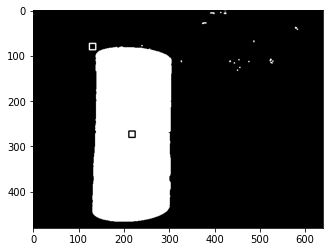

In [9]:
for cen in cens:
    cv2.drawMarker(image_result, (int(cen[0]),int(cen[1])), (0,0,255),cv2.MARKER_SQUARE,15,2)
cv2.drawMarker(image_result, (int(objects[0]["x"]), int(objects[0]["y"])), (255,0,0),cv2.MARKER_SQUARE,15,2)
plt.imshow(image_result,cmap='gray',vmin=0,vmax=255)

In [10]:
detected_objs = []
LEFT=0
COMPLETE = 1
RIGHT=2
for i, obj in enumerate(objects):
    # In the image, object is too close to the left
    if obj["x"] == 0:
        detected_objs.append({"centroid": (cens[i][0], cens[i][1]), "width": obj["width"], "height": obj["height"], "status": LEFT})
    else:
        # In the image, object is too close to the right
        if obj["x"] + obj["width"] == hsv_frame.shape[1]:
            detected_objs.append({"centroid": (cens[i][0], cens[i][1]), "width": obj["width"], "height": obj["height"], "status": RIGHT})
        else:
            detected_objs.append({"centroid": (cens[i][0], cens[i][1]), "width": obj["width"], "height": obj["height"], "status": COMPLETE})

In [11]:
detected_objs

[{'centroid': (218.54179938217263, 273.9996478704163),
  'width': 175,
  'height': 386,
  'status': 1}]